# Tarea N°1 - Desarrollo de Proyectos Y Productos de Datos

## Reestructuración y Evaluación de Modelo de Machine Learning


<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>

</div>

*12 de mayo de 2025*

Carlos Saquel Depaoli

---

# Clasificador de Propinas para Viajes en Taxi en NYC (2020)

Inspirado en la charla ["Keeping up with Machine Learning in Production"](https://github.com/shreyashankar/debugging-ml-talk) de [Shreya Shankar](https://twitter.com/sh_reya)


## Objetivos del Proyecto

Este proyecto implementa una solución modular y profesional para:

1. **Modularización del Código**: Reestructurar el análisis original en componentes reutilizables siguiendo buenas prácticas de ingeniería de software
2. **Evaluación Temporal**: Analizar el comportamiento del modelo a través de múltiples meses de 2020
3. **Detección de Data Drift**: Implementar estrategias para explicar la degradación del modelo en el tiempo
4. **Reproducibilidad**: Garantizar que el proyecto sea ejecutable desde cero

## Descripción del Problema

Este notebook desarrolla un modelo de machine learning para predecir propinas altas en viajes de taxi de Nueva York, usando datos de la NYC Taxi and Limousine Commission (TLC) del año 2020.

**Objetivo**: Identificar viajes donde la propina dejada por el pasajero fue alta, es decir, mayor al 20% del costo del viaje.

**Metodología**: 
- Entrenar un modelo de clasificación binaria Random Forest usando datos de enero 2020
- Evaluar el modelo en datos de febrero a diciembre 2020
- Analizar la degradación del rendimiento y sus causas

## Estrategia de Evaluación Temporal

Para explicar el comportamiento distinto del modelo a lo largo del tiempo, implementamos:

1. **Evaluación Mensual Sistemática**: 
   - Entrenamiento en enero 2020
   - Evaluación mes a mes de febrero a diciembre
   - Métricas: F1-Score, Accuracy, AUC

2. **Análisis de Data Drift**:
   - Comparación estadística de distribuciones entre meses
   - Tests de Kolmogorov-Smirnov y Chi-cuadrado
   - Identificación de variables con mayor drift

3. **Visualización de Resultados**:
   - Gráficos de evolución de métricas
   - Análisis de tamaños de dataset y distribuciones
   - Visualización de drift por variable

4. **Automatización del Proceso**:
   - Pipeline completo modularizado
   - Funciones reutilizables para evaluación multi-mes
   - Generación automática de reportes
4. **Reproducibilidad**: Garantizar que el proyecto sea ejecutable desde cero


## Cargando las librerías necesarias

In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from src.data.dataset import preprocess_data
from src.features.build_features import build_features_data, compare_data_drift_months
from src.modeling.train import train_and_save
from src.modeling.predict import evaluate_model, load_model
from src.visualization.plots import plot_drift, plot_metrics_months, plot_labels_months

## Carga, limpieza y creación de features

El proceso de preparación de datos se ha modularizado en tres etapas principales, implementadas en módulos separados bajo el directorio `src/`:

### 1. Carga de Datos (`src.data.dataset`)

- **Función**: `preprocess_data()`
- **Proceso**:
  - Carga de archivos Parquet desde la fuente de datos de NYC Taxi
  - Almacenamiento de datos crudos en `../data/raw/`
  - Implementación de pipeline completo: load -> clean -> features

### 2. Limpieza Básica (`src.data.dataset`)

- **Función**: `basic_cleaning()`
- **Proceso**:
  - Filtrado de registros válidos
  - Creación de la variable objetivo `high_tip` (propinas > 20% del costo del viaje)
  - Almacenamiento de datos limpios en `../data/interim/`

### 3. Ingeniería de Features (`src.features.build_features`)

- **Función**: `create_features_and_target()`
- **Features Numéricas**:
  - `pickup_weekday`: Día de la semana de recogida (0-6)
  - `pickup_hour`: Hora de recogida (0-23)
  - `pickup_minute`: Minuto de recogida (0-59)
  - `work_hours`: Indicador de horario laboral (L-V, 8-18h)
  - `trip_distance`: Distancia del viaje
  - `trip_time`: Duración del viaje en segundos
  - `trip_speed`: Velocidad promedio del viaje

- **Features Categóricas**:
  - `PULocationID`: ID de la zona de recogida
  - `DOLocationID`: ID de la zona de destino
  - `RatecodeID`: Código de tarifa aplicada

### 4. Procesamiento Final

- **Función**: `build_features_data()`
- **Proceso**:
  - Conversión de tipos de datos para eficiencia
    - Features numéricas y categóricas: `float32`
    - Variable objetivo: `int32`
  - Manejo de valores nulos (reemplazo con -1.0)
  - Almacenamiento del dataset final en `../data/processed/`

Este pipeline se aplica a los datos de cada mes del año 2020, permitiendo un procesamiento consistente y reproducible de los datos históricos.

In [3]:
%%time

numeric_feat = [
    "pickup_weekday",
    "pickup_hour",
    'work_hours',
    "pickup_minute",
    "passenger_count",
    'trip_distance',
    'trip_time',
    'trip_speed'
]
categorical_feat = [
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
]

target_col = "high_tip"

features = numeric_feat + categorical_feat

months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

month_train = '01'
model_path = f'../models/rfc_model_month_{month_train}.joblib'
taxi = {}

print(f'Processing months: {months[0]} to {months[-1]}')
for month in months:
    filepath_month = f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-{month}.parquet'
    save_file_name = f'yellow_tripdata_2020-{month}'
    taxi_ = preprocess_data(filepath_month, save_file_name, target_col, verbose=False)
    taxi[month], _, _ = build_features_data(taxi_, numeric_feat, categorical_feat, save_file_name, target_col, verbose=False)

Processing months: 01 to 12
Datos guardados en ../data/raw/yellow_tripdata_2020-01.parquet con compresión snappy
Datos guardados en ../data/interim/yellow_tripdata_2020-01_clean.parquet con compresión snappy
Datos guardados en ../data/processed/yellow_tripdata_2020-01_processed.parquet con compresión snappy
Datos guardados en ../data/raw/yellow_tripdata_2020-02.parquet con compresión snappy
Datos guardados en ../data/interim/yellow_tripdata_2020-02_clean.parquet con compresión snappy
Datos guardados en ../data/processed/yellow_tripdata_2020-02_processed.parquet con compresión snappy
Datos guardados en ../data/raw/yellow_tripdata_2020-03.parquet con compresión snappy
Datos guardados en ../data/interim/yellow_tripdata_2020-03_clean.parquet con compresión snappy
Datos guardados en ../data/processed/yellow_tripdata_2020-03_processed.parquet con compresión snappy
Datos guardados en ../data/raw/yellow_tripdata_2020-04.parquet con compresión snappy
Datos guardados en ../data/interim/yellow_tr

## Pipeline de Entrenamiento y Evaluación

La automatización del proceso de entrenamiento y evaluación se ha implementado en una función `modeling_pipeline` que realiza las siguientes tareas:

#### 1. Entrenamiento del Modelo

- **Dataset de Entrenamiento**: Datos de enero 2020
- **Algoritmo**: Random Forest Classifier
- **Features Utilizadas**: 
  - 8 variables numéricas (temporales y del viaje)
  - 3 variables categóricas (ubicaciones y tarifa)
- **Variable Objetivo**: Propina alta (>20% del costo)

#### 2. Evaluación Mensual

Para cada mes del año 2020, se calculan las siguientes métricas:

- **Métricas de Rendimiento**:
  - `acc_`: Accuracy por mes
  - `f1_`: F1-Score por mes
  - `auc_`: Área bajo la curva ROC por mes
  - `cr_`: Classification report completo

- **Métricas de Distribución**:
  - `mean_y`: Proporción real de propinas altas
  - `mean_ypred`: Proporción predicha de propinas altas
  - `month_size`: Tamaño del dataset por mes

#### 3. Análisis de Data Drift

Se implementó una función `compare_data_drift_months()` que:

- Compara la distribución de features entre el mes de referencia (enero) y los meses subsiguientes
- Calcula el porcentaje de cambio en las medias de las variables
- Detecta cambios significativos en los patrones de datos

Esta estructura permite un análisis sistemático de la degradación del modelo y los cambios en los patrones de datos a lo largo del tiempo.

In [4]:
def modeling_pipeline(taxi, months, month_train, model_path, numeric_feat, categorical_feat, target_col):
    acc_ = {}
    f1_ = {}
    auc_ = {}
    cr_ = {}
    mean_y = {}
    mean_ypred = {}
    month_size = {}
    features = numeric_feat + categorical_feat

    print("")
    rfc = train_and_save(taxi[month_train][features], taxi[month_train][target_col], model_path)
    print("")

    print(f'Eval months: {months[0]} to {months[-1]}')
    for month in months:
        acc_[month], f1_[month], auc_[month], mean_y[month], mean_ypred[month], cr_[month] = evaluate_model(rfc, taxi[month][features], taxi[month][target_col])
        month_size[month] = len(taxi[month])
    
    return acc_, f1_, auc_, cr_, mean_y, mean_ypred, month_size


In [5]:
%%time

acc_, f1_, auc_, cr_, mean_y, mean_ypred, month_size = modeling_pipeline(taxi, months, month_train, model_path, numeric_feat, categorical_feat, target_col)



Starting training pipeline...
Train: (5106209, 11), Test: (1276553, 11)
Training RandomForest with params: {'n_estimators': 100, 'max_depth': 10, 'random_state': 42, 'n_jobs': -1}
Training completed

Accuracy: 0.600
F1-Score: 0.729
AUC: 0.598
Classification Report:
              precision    recall  f1-score       support
0.0            0.701380  0.140156  0.233627  5.558300e+05
1.0            0.589932  0.953980  0.729035  7.207230e+05
accuracy       0.599629  0.599629  0.599629  5.996288e-01
macro avg      0.645656  0.547068  0.481331  1.276553e+06
weighted avg   0.638458  0.599629  0.513327  1.276553e+06
Model saved to: ../models/rfc_model_month_01.joblib
Pipeline completed.

Eval months: 01 to 12
CPU times: total: 24min 36s
Wall time: 2min 11s


## Análisis de Resultados

### 1. Evolución de Métricas del Modelo

El gráfico de métricas por mes muestra tres indicadores clave:
- **Accuracy**: Precisión general del modelo
- **F1-Score**: Balance entre precisión y recall
- **AUC**: Capacidad discriminativa del modelo

Se observa una tendencia clara de degradación en todas las métricas conforme avanza el año, siendo más pronunciada después de marzo 2020.

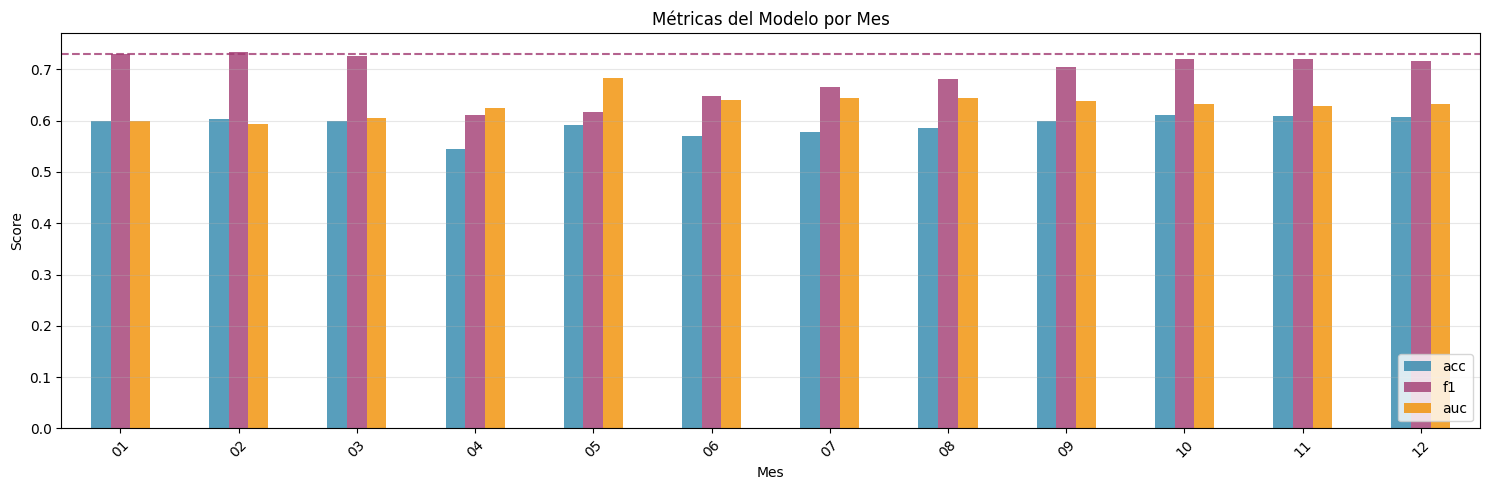

In [6]:
plot_metrics_months(
    pd.concat([
        pd.DataFrame.from_dict(acc_, orient='index', columns=['acc']), 
        pd.DataFrame.from_dict(f1_, orient='index', columns=['f1']),
        pd.DataFrame.from_dict(auc_, orient='index', columns=['auc']),
        ], axis=1), 
    f1_['01'],
    img_save_path = '../reports/figures/metrics_months.png',
    title='Métricas del Modelo por Mes',
    figsize=(15, 5)
)

### 2. Análisis de Distribución de Labels

El gráfico de tamaño y promedios por mes revela:
- **Volumen de Datos**: Caída significativa en el número de viajes
- **Proporción de Propinas Altas**:
  - `mean_y`: Proporción real observada
  - `mean_ypred`: Proporción predicha por el modelo
  - Se observa una divergencia creciente entre valores reales y predichos

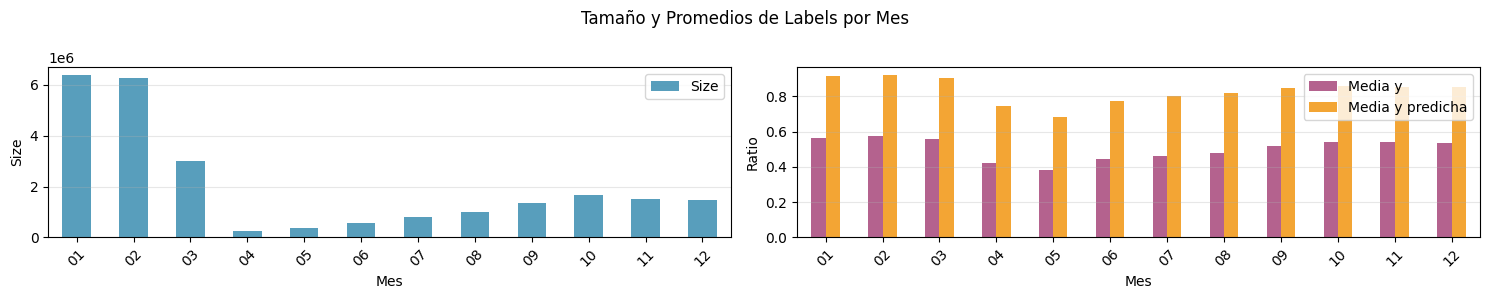

In [7]:
plot_labels_months(
    pd.DataFrame.from_dict(month_size, orient='index', columns=['month_size']), 
    pd.concat([
    pd.DataFrame.from_dict(mean_y, orient='index', columns=['mean_y']),
    pd.DataFrame.from_dict(mean_ypred, orient='index', columns=['mean_ypred'])
    ], axis=1), 
    img_save_path = '../reports/figures/size_means_predicts_months.png',
    figsize=(15, 3), 
    title='Tamaño y Promedios de Labels por Mes'
    )

### 3. Análisis Detallado del Drift

Se realizó un análisis comparativo mes a mes usando la función `compare_data_drift_months()`, tomando enero como mes base. Metodología de Drift Detection:

- Tests de Kolmogorov-Smirnov para variables continuas
- Tests de Chi-cuadrado para variables categóricas
- Cálculo de porcentaje de cambio en medias
- Identificación de variables con drift significativo

Los resultados muestran:

In [8]:
comp_drift = compare_data_drift_months(taxi, taxi['01'].columns[1:], '01')

01 vs 02: 11/12 variables con drift
01 vs 03: 11/12 variables con drift
01 vs 04: 11/12 variables con drift
01 vs 05: 11/12 variables con drift
01 vs 06: 12/12 variables con drift
01 vs 07: 12/12 variables con drift
01 vs 08: 12/12 variables con drift
01 vs 09: 12/12 variables con drift
01 vs 10: 12/12 variables con drift
01 vs 11: 12/12 variables con drift
01 vs 12: 12/12 variables con drift


In [9]:
comp_drift_months = pd.DataFrame()

for month in months[1:]:
    c_drift = comp_drift[month][['variable', 'mean_diff_pct']]
    c_drift['month'] = month
    comp_drift_months = pd.concat([comp_drift_months, c_drift], ignore_index=True)

comp_drift_months = comp_drift_months.pivot(index='variable', columns='month')
comp_drift_months

mean_diff_pct                                              \
month                      02        03         04          05         06   
variable                                                                    
DOLocationID         0.075227  1.056613   7.564236    8.721573   5.650538   
PULocationID         0.078994  0.784034   5.922774    7.367680   4.307583   
RatecodeID           0.116228  1.269012  16.818972   33.073850  17.517868   
high_tip             1.585381  1.247338  25.098282   32.705982  20.958920   
passenger_count      0.307784  3.559396  25.706977   38.143353  23.579484   
pickup_hour          0.574435  1.191804   5.304385    5.840166   4.726462   
pickup_minute        0.052949  0.054274   0.028193    0.108221   0.247680   
pickup_weekday       2.670960  4.641649   8.289067    0.422865  13.479159   
trip_distance        2.230040  6.410627  38.169920  182.800213  40.247842   
trip_speed          20.424035  0.375853  64.308045  296.140948  22.484082   
trip_time            1.210420  1.659154  28.377512   15.272151   9.693217   
work_hours           6.163072  2.481947  22.987097   12.364268  26.307312   

                                                                           \
month                   07         08          09          10          11   
variable                                                                    
DOLocationID      4.028652   3.573545    1.600150    0.485556    0.423402   
PULocationID      2.827245   2.538244    0.325577    0.588352    0.577518   
RatecodeID       14.777279  14.004426   13.945282   13.381733   13.905159   
high_tip         17.933104  14.944591    8.536798    4.324289    4.241615   
passenger_count  20.061335  16.944890   15.681854   14.529330   15.663279   
pickup_hour       2.647625   0.939467    1.203713    0.725642    0.194280   
pickup_minute     0.078988   0.064453    0.143380    0.239166    0.337590   
pickup_weekday    8.205970   4.900402    6.975470    0.221274    6.152698   
trip_distance    47.142184  49.678245   46.409077   20.228665   41.636007   
trip_speed        7.534919  48.835868  897.530061  768.022279  591.117377   
trip_time         7.844157   6.316716   19.525766   25.809718   25.791685   
work_hours       28.331869  17.105967   23.685398   19.363564   21.534979   

                             
month                    12  
variable                     
DOLocationID       0.371612  
PULocationID       0.847140  
RatecodeID        14.322478  
high_tip           5.640196  
passenger_count   15.803707  
pickup_hour        0.048067  
pickup_minute      0.413064  
pickup_weekday    10.602357  
trip_distance    107.793004  
trip_speed       573.263622  
trip_time         28.802038  
work_hours        33.118462


#### Febrero 2020 (Pre-pandemia)
- Cambios moderados en la distribución de features (< 10% en la mayoría)
- Las variables más estables son las temporales (pickup_hour, pickup_weekday)
- Pequeñas variaciones en patrones de viaje

In [10]:
comp_drift['02']

,variable,test_used,statistic,p_value,drift_detected,mean_diff_pct,std_diff_pct,unique_values,rel_sample_size
0,pickup_weekday,ks,0.046198,0.000000e+00,True,2.670960,2.953031,7,0.983407
1,pickup_hour,ks,0.009676,8.976084e-258,True,0.574435,0.741152,24,0.983407
2,work_hours,chi2,10451.444835,0.000000e+00,True,6.163072,0.581432,2,0.983407
3,pickup_minute,ks,0.000701,8.881731e-02,False,0.052949,0.029801,60,0.983407
4,passenger_count,ks,0.002948,2.582128e-24,True,0.307784,1.025951,11,0.983407
5,trip_distance,ks,0.005313,5.247518e-78,True,2.230040,51.567289,6175,0.983407
6,trip_time,ks,0.017205,0.000000e+00,True,1.210420,2.465869,14750,0.983407
7,trip_speed,ks,0.035414,0.000000e+00,True,20.424035,8.574685,1102567,0.983407
8,PULocationID,ks,0.004083,2.927725e-46,True,0.078994,0.005495,261,0.983407
9,DOLocationID,ks,0.003132,2.171517e-27,True,0.075227,0.199954,262,0.983407



#### Abril 2020 (Inicio de Pandemia)
- Cambios drásticos en casi todas las variables (> 25% en variables críticas)
- Mayores variaciones en:
  - Número de pasajeros
  - Distancia y duración de viajes
  - Patrones de ubicación (PU/DOLocationID)

In [11]:
comp_drift['04']

,variable,test_used,statistic,p_value,drift_detected,mean_diff_pct,std_diff_pct,unique_values,rel_sample_size
0,pickup_weekday,ks,0.064364,0.000000,True,8.289067,2.427446,7,0.03707
1,pickup_hour,ks,0.110828,0.000000,True,5.304385,14.404601,24,0.03707
2,work_hours,chi2,10419.144963,0.000000,True,22.987097,0.738914,2,0.03707
3,pickup_minute,ks,0.002493,0.117235,False,0.028193,0.116271,60,0.03707
4,passenger_count,ks,0.118706,0.000000,True,25.706977,3.306232,11,0.03707
5,trip_distance,ks,0.051143,0.000000,True,38.169920,255.013559,5707,0.03707
6,trip_time,ks,0.177477,0.000000,True,28.377512,26.641055,11953,0.03707
7,trip_speed,ks,0.376380,0.000000,True,64.308045,68.695744,778326,0.03707
8,PULocationID,ks,0.112304,0.000000,True,5.922774,7.943277,261,0.03707
9,DOLocationID,ks,0.103424,0.000000,True,7.564236,6.506650,262,0.03707



#### Octubre 2020 (Consolidación de Cambios)
- Establecimiento de nuevos patrones de comportamiento
- Variables más afectadas:
  - Patrones temporales (work_hours)
  - Características del viaje (distance, time, speed (> 700%))
  - Zonas de recogida y destino

In [12]:
comp_drift['10']

,variable,test_used,statistic,p_value,drift_detected,mean_diff_pct,std_diff_pct,unique_values,rel_sample_size
0,pickup_weekday,ks,0.024202,0.000000e+00,True,0.221274,1.658468,7,0.26212
1,pickup_hour,ks,0.061311,0.000000e+00,True,0.725642,15.444402,24,0.26212
2,work_hours,chi2,42829.448097,0.000000e+00,True,19.363564,0.317259,2,0.26212
3,pickup_minute,ks,0.005176,2.874572e-31,True,0.239166,0.115905,60,0.26212
4,passenger_count,ks,0.054660,0.000000e+00,True,14.529330,1.211169,11,0.26212
5,trip_distance,ks,0.027805,0.000000e+00,True,20.228665,236.916875,5858,0.26212
6,trip_time,ks,0.023953,0.000000e+00,True,25.809718,61.791255,12749,0.26212
7,trip_speed,ks,0.071733,0.000000e+00,True,768.022279,179.625537,857393,0.26212
8,PULocationID,ks,0.041489,0.000000e+00,True,0.588352,3.622970,261,0.26212
9,DOLocationID,ks,0.026381,0.000000e+00,True,0.485556,2.616742,262,0.26212


### ¿El modelo mantiene un rendimiento consistente?

**No**. El análisis revela una degradación sistemática:
- **Pre-pandemia** (Enero-Marzo): Rendimiento estable con ligera degradación
- **Pandemia inicial** (Abril-Mayo): Caída abrupta en todas las métricas
- **Periodo intermedio** (Junio-Noviembre): Rendimiento degradado pero estabilizado
- **Fin de año** (Diciembre): Recuperación parcial

### ¿Qué factores explican la variación en el desempeño?

1. **Impacto de la Pandemia**:
   - Cambios fundamentales en movilidad urbana
   - Reducción drástica en volumen de viajes
   - Modificación de patrones de propinas

2. **Data Drift Multivariable**:
   - Cambios en distribuciones de todas las features
   - Variables más afectadas: trip_speed, passenger_count, work_hours
   - Nuevos patrones de ubicaciones de recogida/destino

3. **Cambios Socioeconómicos**:
   - Alteración en hábitos de consumo
   - Diferentes demografías de usuarios
   - Modificación en tipos de viajes (esenciales vs recreativos)

### ¿Qué acciones recomendarías para mejorar la robustez?

1. **Reentrenamiento Adaptativo**:
   - Pipeline de reentrenamiento mensual automatizado
   - Ventanas móviles de datos de entrenamiento
   - Validación continua en datos recientes

2. **Monitoreo del Drift**:
   - Sistema de alertas automáticas
   - Dashboard de métricas en tiempo real
   - Umbrales de degradación predefinidos

3. **Feature Engineering Contextual**:
   - Incorporar variables de contexto temporal
   - Indicadores de eventos especiales (pandemia, festividades)
   - Features de tendencias móviles
